In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from keras.layers import LSTM, Input, Dense, Conv1D, Flatten, BatchNormalization, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

In [162]:
df = pd.read_csv("IMOEX_150101_221201.csv")
df = df.drop(["<TIME>", "<TICKER>", "<PER>"], axis=1)
df["<DATE>"] = pd.to_datetime(df["<DATE>"], format="%Y%m%d")
df

,<DATE>,<CLOSE>
0,2015-01-05,1435.66
1,2015-01-06,1480.73
2,2015-01-08,1547.39
3,2015-01-09,1515.37
4,2015-01-12,1513.22
...,...,...
1975,2022-11-28,2177.45
1976,2022-11-29,2185.32
1977,2022-11-30,2174.53
1978,2022-12-01,2187.29


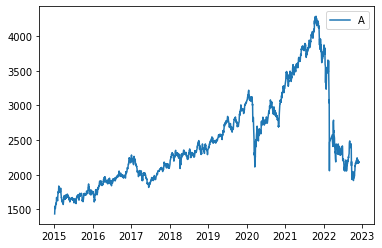

In [163]:
plt.plot(df["<DATE>"], df["<CLOSE>"])
plt.legend("Акции МосБиржи с 2021г.")

Load data from Google trends

In [165]:
df_group = pd.DataFrame()
yrange = range(2015, 2023)
prefix = "_аспци"
for table in [f"keywords//{n}{prefix}.csv" for n in yrange]:
    df_year = pd.read_csv(table, header=1)
    df_year["Неделя"] = pd.to_datetime(df_year["Неделя"], format="%Y-%m-%d")
    df_group = pd.concat([df_group, df_year])
df_group
res = []
for d in df.index:
    trends_on_date = df_group[df_group["Неделя"] < df.loc[d, "<DATE>"]].iloc[-1, 1:].values
    res.append([df.loc[d, "<DATE>"], *trends_on_date, df.loc[d, "<CLOSE>"]])
res = pd.DataFrame(res, columns = ["Date", *df_group.columns[1:], "Price"])
res.to_csv("test.csv")
res = res.set_index("Date")
res

,Неделя,Акция: (Россия),Экономические санкции: (Россия),Правительство: (Россия),Центральный банк: (Россия),Инвестиция: (Россия)
0,2015-01-04,27,41,0,0,0
1,2015-01-11,24,65,39,0,0
2,2015-01-18,25,92,36,0,0
3,2015-01-25,30,60,0,0,32
4,2015-02-01,0,35,0,0,0
...,...,...,...,...,...,...
45,2022-11-13,4,3,3,14,0
46,2022-11-20,7,10,0,0,0
47,2022-11-27,0,0,0,0,0
48,2022-12-04,4,9,0,5,4


In [170]:
res = []
for d in df.index:
    trends_on_date = df_group[df_group["Неделя"] < df.loc[d, "<DATE>"]].iloc[-1, 1:].values
    res.append([df.loc[d, "<DATE>"], *trends_on_date, df.loc[d, "<CLOSE>"]])
res = pd.DataFrame(res, columns = ["Date", *df_group.columns[1:], "Price"])
res.to_csv("test.csv")
res = res.set_index("Date")
res

,Акция: (Россия),Экономические санкции: (Россия),Правительство: (Россия),Центральный банк: (Россия),Инвестиция: (Россия),Price
Date,,,,,,
2015-01-05,27,41,0,0,0,1435.66
2015-01-06,27,41,0,0,0,1480.73
2015-01-08,27,41,0,0,0,1547.39
2015-01-09,27,41,0,0,0,1515.37
2015-01-12,24,65,39,0,0,1513.22
...,...,...,...,...,...,...
2022-11-28,0,0,0,0,0,2177.45
2022-11-29,0,0,0,0,0,2185.32
2022-11-30,0,0,0,0,0,2174.53


In [171]:
scaler = StandardScaler()
scaler = scaler.fit(res)
pricedata_scaled = scaler.transform(res)
pricedata_scaled

array([[-0.02897274,  1.38288472, -0.671021  , -0.42264463, -0.63463548,
        -1.57482296],
       [-0.02897274,  1.38288472, -0.671021  , -0.42264463, -0.63463548,
        -1.5065188 ],
       [-0.02897274,  1.38288472, -0.671021  , -0.42264463, -0.63463548,
        -1.40549471],
       ...,
       [-1.24952661, -0.68418546, -0.671021  , -0.42264463, -0.63463548,
        -0.45505594],
       [-1.24952661, -0.68418546, -0.671021  , -0.42264463, -0.63463548,
        -0.435718  ],
       [-1.24952661, -0.68418546, -0.671021  , -0.42264463, -0.63463548,
        -0.44609926]])

Построим матрицу корреляции

In [198]:
pd.DataFrame(pricedata_scaled, columns = [ *df_group.columns[1:], "Price"]).corr()

,Акция: (Россия),Экономические санкции: (Россия),Правительство: (Россия),Центральный банк: (Россия),Инвестиция: (Россия),Price
Акция: (Россия),1.000000,0.069323,0.116341,0.150473,0.125459,0.210781
Экономические санкции: (Россия),0.069323,1.000000,0.136212,0.082252,0.052661,-0.178249
Правительство: (Россия),0.116341,0.136212,1.000000,0.008481,-0.064855,-0.144259
Центральный банк: (Россия),0.150473,0.082252,0.008481,1.000000,0.017278,0.045170
Инвестиция: (Россия),0.125459,0.052661,-0.064855,0.017278,1.000000,0.117072
Price,0.210781,-0.178249,-0.144259,0.045170,0.117072,1.000000


### Training

Lets try to train model on that data

Split on train and test. X - trends and last prices, y - price after window

In [252]:
winsize = 14
X = []
y = []
for i in range(pricedata_scaled.shape[0]-winsize):
    X.append(pricedata_scaled[i:i+winsize])
    y.append(pricedata_scaled[i+winsize, -1])
X = np.array(X)
y = np.array(y)
tsplit_idx = int(len(X)*0.8)
X_train, X_test, y_train, y_test = X[:1458], X[1458:], y[:1458], y[1458:]

print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")

X shape (1458, 14, 6) test shape (508, 14, 6) y shape (1458,)


We will use LSTM with 128 units

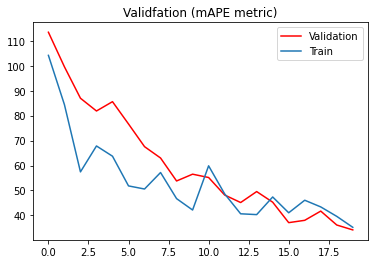

16/16 [==============================] - 1s 11ms/step
mAPE: 0.34193%
MSE (scaled): 0.070199
R2: 0.94


In [256]:
model = Sequential()
param_num=X_train.shape[2]
model.add(Input((winsize, param_num)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(metrics="mape", loss="mse")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=0)

plt.plot(history.history["val_mape"], "r-")
plt.plot(history.history["mape"])
plt.title("Validfation (mAPE metric)")
plt.legend(["Validation", "Train"])
plt.show()
y_pred = model.predict(X_test)
print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

Plot stock price real and presdicted by model

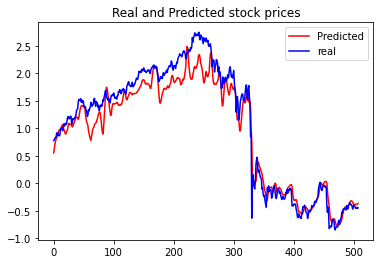

In [257]:
plt.plot(y_pred, "r")
plt.plot(y_test, "b-")
plt.legend(["Predicted", "real"])
plt.title("Real and Predicted stock prices")
plt.show()

But What if we will predict not price but the movement

### Compare with only last prices

In [247]:
winsize = 14
X = []
y = []
for i in range(pricedata_scaled.shape[0]-winsize):
    X.append(pricedata_scaled[i:i+winsize, -1:])
    y.append(pricedata_scaled[i+winsize, -1])
X = np.array(X)
y = np.array(y)
tsplit_idx = int(len(X)*0.75)
X_train, X_test, y_train, y_test = X[:tsplit_idx], X[tsplit_idx:], y[:tsplit_idx], y[tsplit_idx:]

print(f"X shape {X_train.shape} test shape {X_test.shape} y shape {y_train.shape}")

X shape (1474, 14, 1) test shape (492, 14, 1) y shape (1474,)


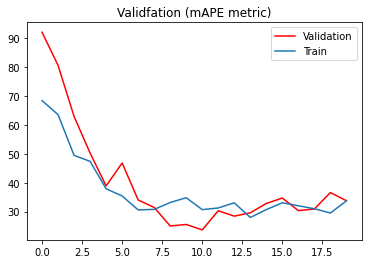

16/16 [==============================] - 0s 4ms/step
mAPE: 0.33773%
MSE (scaled): 0.012051
R2: 0.99


In [248]:
model = Sequential()
param_num=X_train.shape[2]
model.add(Input((winsize, param_num)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(metrics="mape", loss="mse")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=0)

plt.plot(history.history["val_mape"], "r-")
plt.plot(history.history["mape"])
plt.title("Validfation (mAPE metric)")
plt.legend(["Validation", "Train"])
plt.show()
y_pred = model.predict(X_test)
print(f"mAPE: {round(mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred), 5)}%")
print(f"MSE (scaled): {round(mean_squared_error(y_true=y_test, y_pred=y_pred), 6)}")
print(f"R2: {round(r2_score(y_true=y_test, y_pred=y_pred), 2)}")

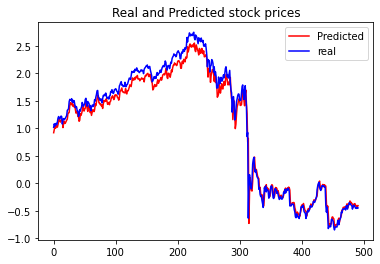

In [251]:
plt.plot(y_pred, "r")
plt.plot(y_test, "b-")
plt.legend(["Predicted", "real"])
plt.title("Real and Predicted stock prices")
plt.show()